<a href="https://colab.research.google.com/github/annisaeka123/2341720131_ML_2025/blob/main/UAS/UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline:

segmentasi > augmentasi > ekstraksi fitur ( HOG + LBP) > PCA > SVM > prediksi.

Model ini menggunakan pendekatan classic machine learning dengan tahapan:

1. Segmentasi

Menggunakan GrabCut untuk menghilangkan background sehingga model hanya fokus ke objek sayur.

Dipilih karena:

- GrabCut mampu memisahkan objek dari background dengan cukup baik meskipun gambar memiliki latar belakang kompleks.

- Mengurangi noise dari area yang tidak relevan, sehingga proses ekstraksi fitur menjadi lebih fokus pada objek.

- Tidak memerlukan anotasi manual (masking).


Tujuan: meningkatkan kualitas fitur yang diekstraksi.

2. Augmentasi Data

Digunakan untuk meningkatkan variasi data agar model lebih robust terhadap rotasi, pencahayaan, dan orientasi.

Dipilih karena:

- Dataset relatif terbatas dan augmentasi menambah variasi pose, rotasi, dan pencahayaan.

- Mengurangi overfitting dan meningkatkan generalisasi model.

Tujuan: memperkuat kemampuan model menghadapi variasi input.

3. Ekstraksi Fitur

a. HOG (Histogram of Oriented Gradient) untuk menangkap struktur bentuk (shape & edges).

Dipakai karena:

- HOG efektif untuk menangkap struktur bentuk dan tepi objek.

- Banyak sayur memiliki karakteristik bentuk yang cukup unik (contoh: sawi panjang, cabai kurus, bunga kol bertekstur bulat), sehingga HOG cocok sebagai pembeda antar kelas.

- HOG merupakan metode ringan dan efisien secara komputasi, cocok untuk implementasi mobile.

Tujuan: merepresentasikan bentuk objek dengan kuat.

b. LBP (Local Binary Pattern) untuk merepresentasikan pola tekstur permukaan objek.

Dipakai karena:

- LBP sangat baik dalam menangkap pola tekstur permukaan.

- Objek makanan seperti sayur memiliki perbedaan tekstur yang signifikan (misal: tekstur kasar bunga kol, licin cabai, berlapis pada sawi).

- LBP tahan terhadap perubahan pencahayaan sehingga lebih stabil dibanding fitur berbasis warna.

Tujuan: menambahkan informasi tekstur untuk meningkatkan akurasi klasifikasi.


-> Kedua fitur kemudian digabungkan menjadi vektor fitur tunggal.

-> Tidak menggunakan ekstraksi warna karena pada 1 label/jenis sayur ada yang berbeda-beda warna. Takut membuat fitur tidak konsisten.


4. Dimensionality Reduction PCA (Principal Component Analysis)

Digunakan untuk mengurangi dimensi fitur supaya training lebih efisien dan menghindari overfitting.

Dipilih karena:

- Vektor fitur gabungan HOG + LBP memiliki dimensi besar. PCA membantu mereduksi dimensi tanpa kehilangan informasi penting.

- Mengurangi waktu komputasi saat training dan inference.

- Mengurangi risiko overfitting karena fitur yang redundan dihilangkan.

Tujuan: menyederhanakan fitur dan mempercepat klasifikasi.

5. Klasifikasi Menggunakan SVM (Support Vector Machine)

SVM dilatih menggunakan parameter terbaik dari GridSearchCV untuk mendapatkan model yang paling optimal.

Dipilih karena:

- SVM bekerja sangat baik pada dataset dengan ukuran relatif kecil hingga menengah.

- SVM mampu menangani data non-linear menggunakan kernel RBF.

- Stabil, tidak memerlukan training besar dan hasilnya konsisten.

Tujuan: mendapatkan model klasifikasi yang akurat, stabil, dan efisien.

6. Prediksi

Model memberikan kelas sayur beserta nilai confidence.

In [ ]:
!pip install albumentations



In [ ]:
import os
import cv2
import numpy as np


In [ ]:
def segment_grabcut(img):
    mask = np.zeros(img.shape[:2], np.uint8)

    h, w = img.shape[:2]
    rect = (int(w*0.15), int(h*0.15), int(w*0.7), int(h*0.7))  # lebih ketat

    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")

    # perbaiki tepi dengan morphological closing
    kernel = np.ones((5,5), np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)

    return img * mask2[:, :, np.newaxis]


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern

# ---------------------------
# HOG FEATURE EXTRACTION
# ---------------------------
def extract_hog_features(img):
    # konversi ke grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # resize agar konsisten (opsional)
    gray = cv2.resize(gray, (128, 128))

    # ekstraksi HOG
    hog_features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        transform_sqrt=True
    )
    return hog_features


# ---------------------------
# LBP FEATURE EXTRACTION
# ---------------------------
def extract_lbp_features(img, P=8, R=1):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (128, 128))

    # compute LBP
    lbp = local_binary_pattern(gray, P, R, method="uniform")

    # hitung histogram LBP (jumlah bin = P+2)
    (hist, _) = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, P + 3),
        range=(0, P + 2)
    )

    # normalisasi histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist


# ---------------------------
# GABUNGKAN FEATURES (HOG + LBP)
# ---------------------------
def extract_features(img):
    hog_feat = extract_hog_features(img)
    lbp_feat = extract_lbp_features(img)

    # gabungkan kedua fitur menjadi satu vektor
    feature_vector = np.hstack([hog_feat, lbp_feat])
    return feature_vector


In [ ]:
import os
import cv2
import numpy as np
import albumentations as A

augment_times = 3

augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Affine(translate_percent=0.1, scale=(0.8,1.2), rotate=(-20,20), p=0.6),
])

X = []
y = []

DATASET_DIR = r"images/dataset"

for label in os.listdir(DATASET_DIR):

    class_folder = os.path.join(DATASET_DIR, label)
    if not os.path.isdir(class_folder):
        continue

    print(f"Processing: {label}...")

    for file in os.listdir(class_folder):

        img_path = os.path.join(class_folder, file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping corrupted file: {img_path}")
            continue

        # --- ORIGINAL FILE ---
        segmented = segment_grabcut(img)
        X.append(extract_features(segmented))
        y.append(label)

        # --- AUGMENTATION LOOP ---
        for _ in range(augment_times):

            aug_img = augmenter(image=img)["image"]

            segmented_aug = segment_grabcut(aug_img)
            X.append(extract_features(segmented_aug))
            y.append(label)

X = np.array(X)
y = np.array(y)

print("\nDataset shape:", X.shape)
print("Total samples:", len(X))


Processing: bunga_kol...
Processing: cabai...
Processing: kubis...
Processing: sawi_hijau...
Processing: sawi_putih...

Dataset shape: (1200, 8110)
Total samples: 1200



 Optimizing model with PCA + GridSearchCV...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

 Best Parameters Found: {'pca__n_components': 120, 'svm__C': 100, 'svm__class_weight': {0: 2.0, 1: 1.2, 2: 2.0, 3: 1.2, 4: 2.0}, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

 Accuracy: 0.7166666666666667

 Classification Report:
               precision    recall  f1-score   support

   bunga_kol       0.58      0.98      0.73        48
       cabai       0.90      0.58      0.71        48
       kubis       0.72      0.58      0.64        48
  sawi_hijau       0.82      0.75      0.78        48
  sawi_putih       0.73      0.69      0.71        48

    accuracy                           0.72       240
   macro avg       0.75      0.72      0.71       240
weighted avg       0.75      0.72      0.71       240


 Prediction Confidence per Test Sample:

Sample 1: Predicted = bunga_kol | Confidence = 89.43%
Sample 2: Predicted = sawi_hijau | Confidence = 89.36%
Sample 3: Predicted 

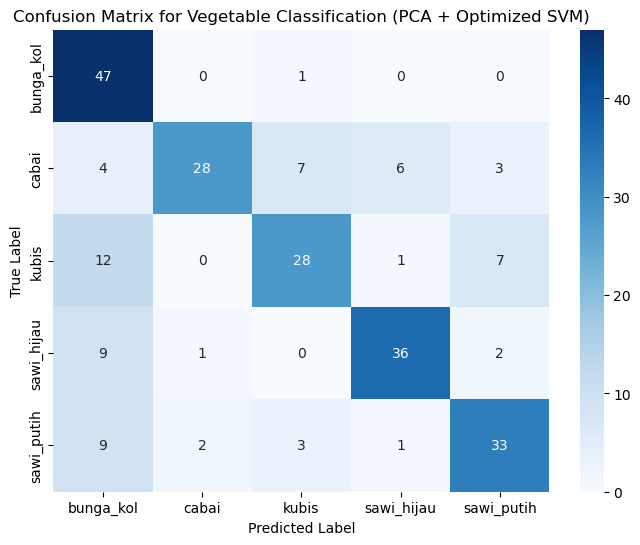

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# 1) Encode Label
# -----------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -----------------------------
# 2) Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

print("\n Optimizing model with PCA + GridSearchCV...")

# -----------------------------
# 3) Pipeline: Scaler → PCA → SVM
# -----------------------------
pipeline = Pipeline([
    ('pca', PCA()),               # reducing dimensionality
    ('svm', SVC(probability=True)) # classifier
])

# -----------------------------
# 4) Parameter Search Space
# -----------------------------
param_grid = {
    'pca__n_components': [120, 150, 200, 250],
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
    'svm__class_weight': [
        {0:2.0, 1:1.2, 2:2.0, 3:1.2, 4:2.0},
    ]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n Best Parameters Found:", grid.best_params_)

# Pakai model terbaik
model = grid.best_estimator_

# -----------------------------
# 5) Evaluation
# -----------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# -----------------------------
# 6) Confidence per Sample
# -----------------------------
print("\n Prediction Confidence per Test Sample:\n")
for i in range(len(y_pred)):
    predicted_label = le.classes_[y_pred[i]]
    confidence = np.max(y_prob[i]) * 100
    print(f"Sample {i+1}: Predicted = {predicted_label} | Confidence = {confidence:.2f}%")

# -----------------------------
# 7) Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Vegetable Classification (PCA + Optimized SVM)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def predict_and_show(image_path, model, le):
    # Load gambar
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Segmentasi (fungsi kamu tetap sama)
    segmented = segment_grabcut(img_rgb)

    # Ekstraksi fitur (fungsi kamu tetap sama)
    features = extract_features(segmented)

    # Karena model pipeline (Scaler + PCA + SVM), kita tidak scaling manual
    features_pipeline = np.array(features).reshape(1, -1)

    # Prediksi label
    pred = model.predict(features_pipeline)[0]
    label = le.inverse_transform([pred])[0]

    # ---- Confidence ----
    prob = model.predict_proba(features_pipeline)[0]
    confidence = np.max(prob) * 100
    conf_label = f"{label} ({confidence:.2f}%)"

    # ---- Visualisasi ----
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmented)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.bar(range(len(features)), features)
    plt.title(f"Extracted Features\nPrediction: {conf_label}")
    plt.xlabel("Feature Index")
    plt.ylabel("Value")

    plt.show()

    return label, confidence


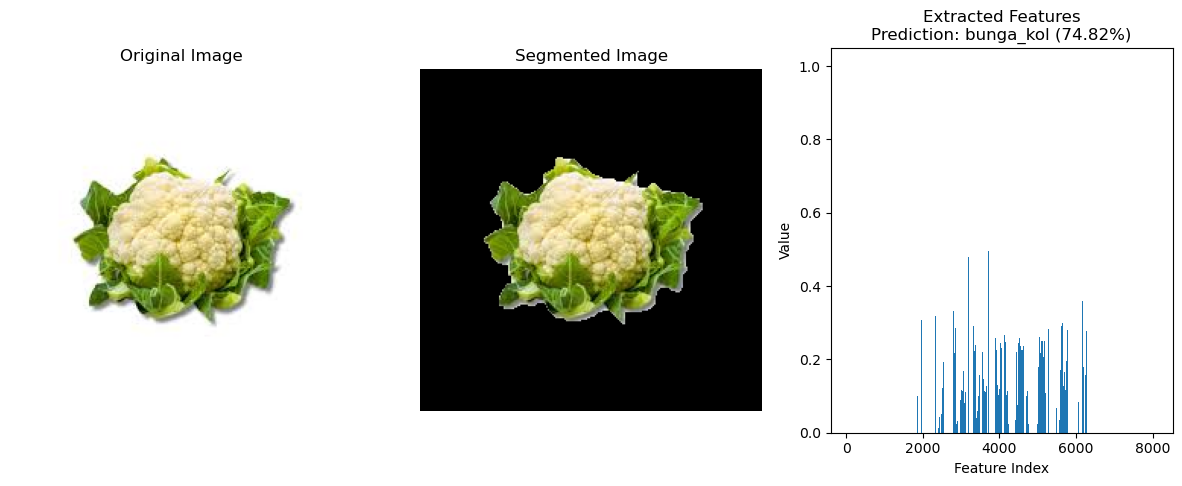


Prediksi: bunga_kol | Confidence: 74.82%


In [ ]:
label, conf = predict_and_show("images/random_test/random_test1.jpg", model, le)
print("\nPrediksi:", label, "| Confidence:", f"{conf:.2f}%")


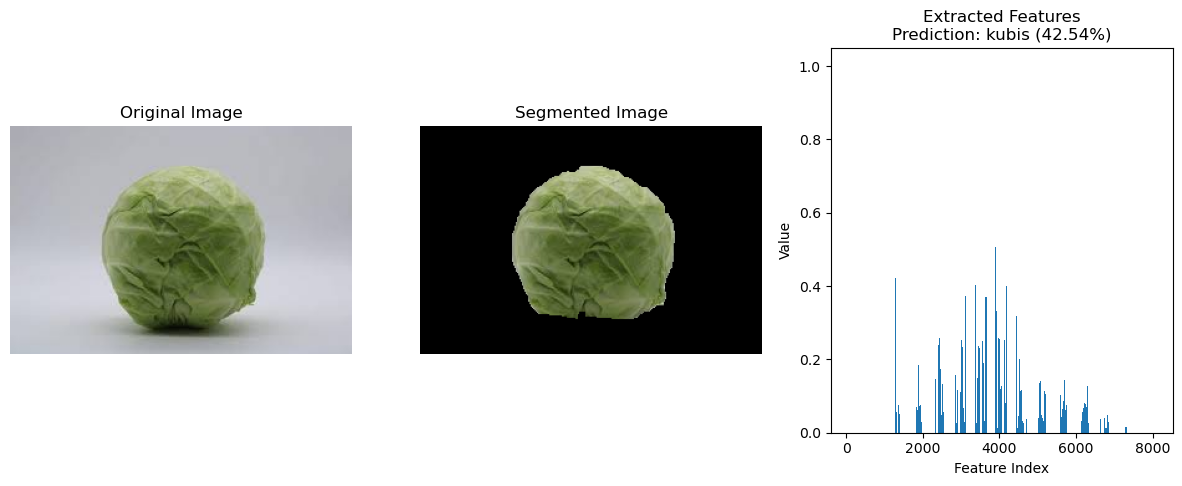


Prediksi: kubis | Confidence: 42.54%


In [ ]:
label, conf = predict_and_show("images/random_test/random_test2.jpg", model, le)
print("\nPrediksi:", label, "| Confidence:", f"{conf:.2f}%")

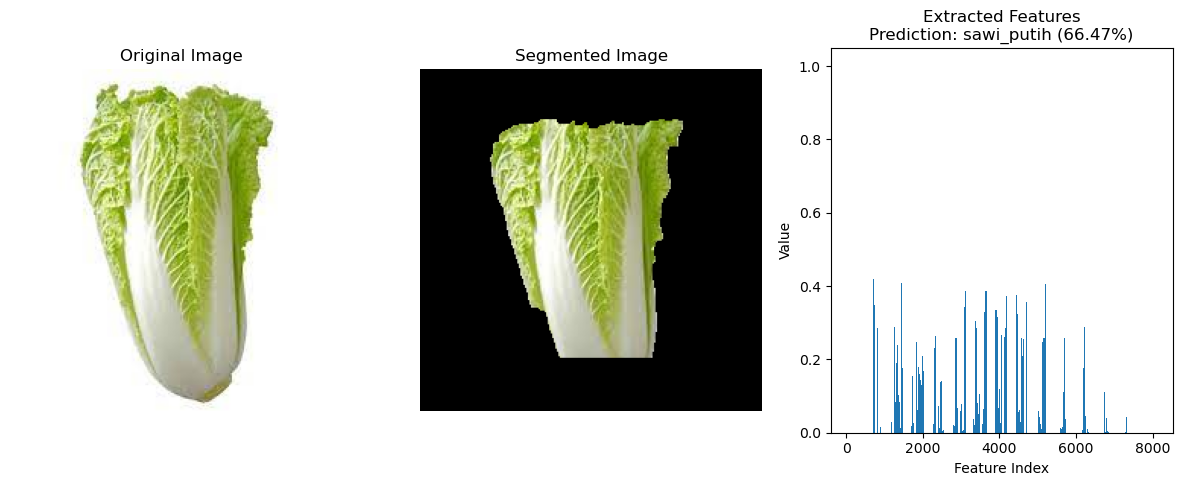


Prediksi: sawi_putih | Confidence: 66.47%


In [ ]:
label, conf = predict_and_show("images/random_test/random_test3.jpg", model, le)
print("\nPrediksi:", label, "| Confidence:", f"{conf:.2f}%")

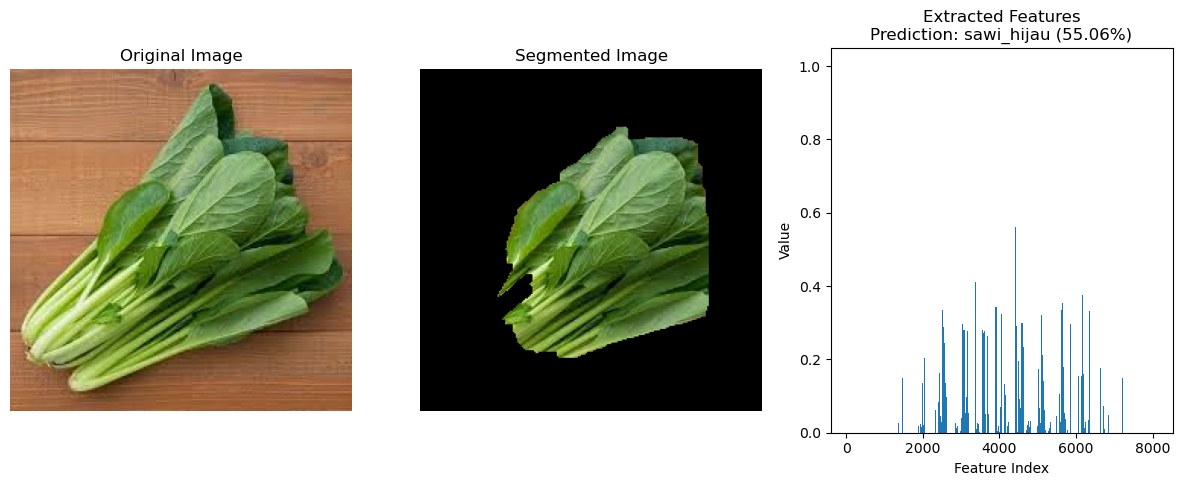


Prediksi: sawi_hijau | Confidence: 55.06%


In [ ]:
label, conf = predict_and_show("images/random_test/random_test4.jpg", model, le)
print("\nPrediksi:", label, "| Confidence:", f"{conf:.2f}%")

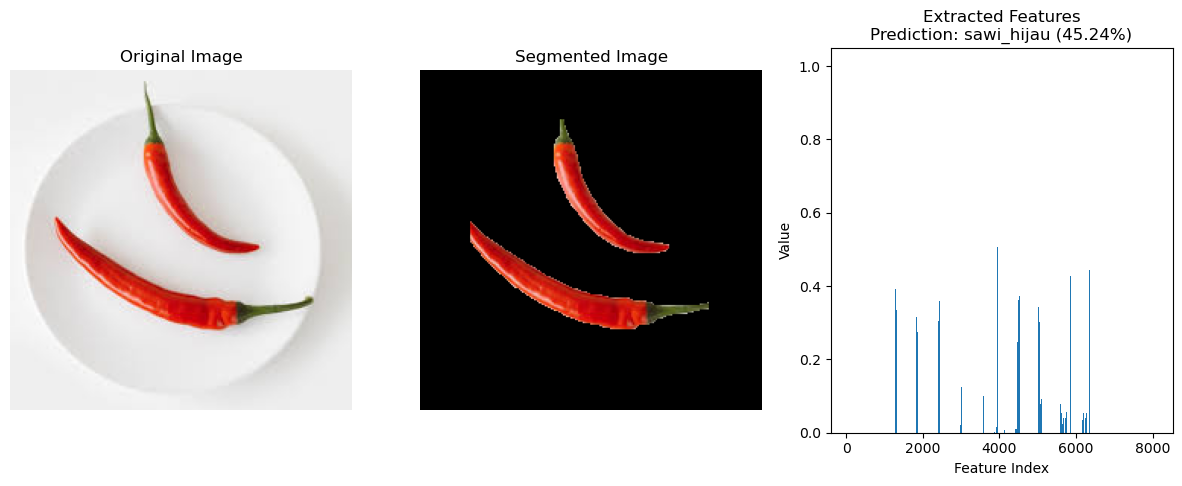


Prediksi: sawi_hijau | Confidence: 45.24%


In [ ]:
label, conf = predict_and_show("images/random_test/random.jpg", model, le)
print("\nPrediksi:", label, "| Confidence:", f"{conf:.2f}%")

In [ ]:
import joblib

best_model = grid.best_estimator_

joblib.dump(best_model, "model_sayur.pkl")

print("Model berhasil disimpan sebagai model_sayur.pkl")

Model berhasil disimpan sebagai model_sayur.pkl


In [ ]:
print(model)

Pipeline(steps=[('pca', PCA(n_components=120)),
                ('svm',
                 SVC(C=100,
                     class_weight={0: 2.0, 1: 1.2, 2: 2.0, 3: 1.2, 4: 2.0},
                     probability=True))])
